# Import Lib

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import warnings
import nltk 
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score,recall_score, accuracy_score, make_scorer, f1_score
from sklearn.model_selection import cross_val_score,train_test_split, cross_validate
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from pandarallel import pandarallel
from os import walk
from wordcloud import WordCloud, STOPWORDS
from time import time

# disable unuseful warnings
def warn(*args, **kwargs):
    pass

warnings.warn = warn

# Import Data

In [7]:
# Read the urls database
urls_df = pd.read_csv(r'phishing_site_urls.csv')

# Rename the column
urls_df.rename(columns = {'URL':'Content'}, inplace = True)

# Change label "bad" in 0 and "good" in 1
urls_df.loc[urls_df["Label"]=="bad", "Label"]= 0
urls_df.loc[urls_df["Label"]=="good", "Label"]= 1
urls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  549346 non-null  object
 1   Label    549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [8]:
label_counter = pd.DataFrame(urls_df.Label.value_counts())

In [9]:
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.show()

1    392924
0    156422
Name: Label, dtype: int64


,Content,Label
1837,Subject: fw : picture\n >\n >\n > the followin...,1
22721,"Subject: congratulation , winning notification...",0
8357,Subject: re : uk : reconciling the spreadsheet...,1
26176,Subject: cheap pharmacy im\n want cheap and ne...,0
27704,Subject: get back to me please\n authentic rep...,0
8825,Subject: ljm model\n ryan :\n this is the upda...,1
4851,"Subject: re :\n denise ,\n no problem .\n we s...",1
7364,Subject: re : revised draft of the assignment ...,1
4260,Subject: hoping for portland :\n hey there ogr...,1
11004,Subject: re : solarc\n didn ' t get a commitme...,1


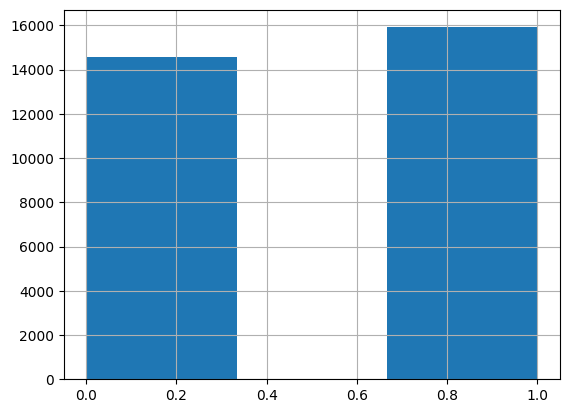

In [10]:
# Read the emails dataset
pathwalk = walk(r"enron-spam/")

allHamData, allSpamData = [], []
for root, dr, file in pathwalk:
    if 'ham' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allHamData.append(" ".join(ip.readlines()))

    elif 'spam' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allSpamData.append(" ".join(ip.readlines()))
                
# remove all redundant data
allHamData = list(set(allHamData))
allSpamData = list(set(allSpamData))

# merge it in a dataframe
hamPlusSpamData = allHamData + allSpamData

# Labels: "bad" = 0 and "good" = 1
labels = [1]*len(allHamData) + [0]*len(allSpamData)

emails_df = pd.DataFrame({"Content": hamPlusSpamData, "Label": labels})

# get an overview of the data
emails_df.Label.hist(bins=3)
emails_df.sample(10)

In [11]:
df = pd.concat([urls_df, emails_df], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579840 entries, 0 to 30493
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  579840 non-null  object
 1   Label    579840 non-null  object
dtypes: object(2)
memory usage: 13.3+ MB


In [12]:
label_counter = pd.DataFrame(df.Label.value_counts())
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.show()

1    408834
0    171006
Name: Label, dtype: int64


### Visualization

In [13]:
bad_words = df[df.Label == 0]
good_words = df[df.Label == 1]
bad_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171006 entries, 0 to 30493
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  171006 non-null  object
 1   Label    171006 non-null  object
dtypes: object(2)
memory usage: 3.9+ MB


In [14]:
good_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408834 entries, 18231 to 15909
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  408834 non-null  object
 1   Label    408834 non-null  object
dtypes: object(2)
memory usage: 9.4+ MB


# Pipeline

In [15]:
stopwords = nltk.corpus.stopwords.words('english')
snow_stemmer = SnowballStemmer('english')

In [16]:
analyzer = CountVectorizer(stop_words = stopwords).build_analyzer()

In [17]:
def snowball_analyzer(doc):
    return [snow_stemmer.stem(w) for w in analyzer(doc)]

In [18]:
#tfidf = TfidfVectorizer()
'''
vect_data = analyzer.fit_transform(df.Content)

clf = svm.SVC(kernel='linear', C=100) 
scores = cross_validate.cross_val_score(clf, vect_data, df.Label, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() / 2))
'''

'\nvect_data = analyzer.fit_transform(df.Content)\n\nclf = svm.SVC(kernel=\'linear\', C=100) \nscores = cross_validate.cross_val_score(clf, vect_data, df.Label, cv=10)\n\nprint("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() / 2))\n'

In [19]:
def print_metrics(results):
    metrics = ['accuracy','precision_ham', 'recall_ham','precision_spam', 'recall_spam']
    for metric in metrics:
        print(f'{metric:15}', np.round(results["test_"+metric].mean(),3), [np.round(elem,3) for elem in results["test_"+metric]])
    print()
    print(f'{"vocabulary size":15}', np.mean([len(results['estimator'][i][0].vocabulary_) for i in range(n_folds)]))
    print(f'{"fit_time":15}', np.round(results["fit_time"].mean()))
    print(f'{"score_time":15}', np.round(results["score_time"].mean()))

### Random Undersampling

In [20]:
# Separate the majority and minority classes
majority_class = df[df['Label'] == 1]
minority_class = df[df['Label'] == 0]

# Undersample the majority class
undersampled_majority_class = majority_class.sample(n=len(minority_class), random_state=42)

# Combine the undersampled majority class with the minority class
undersampled_df = pd.concat([undersampled_majority_class, minority_class])

# Shuffle the rows of the combined dataset
undersampled_df = undersampled_df.sample(frac=1, random_state=42)

# Reset the index
undersampled_df = undersampled_df.reset_index(drop=True)
undersampled_df.sample(10)


,Content,Label
79910,'services.runescape.co.cm/m=forums/forums.vs?1...,0
144725,eoresto.com/jamison-mike-schaeffer-psychiatry/,1
123182,en.wikipedia.org/wiki/1978_World_Junior_Ice_Ho...,1
311516,spoke.com/info/p6R98ra/DonJohnson,1
34699,fullsongs.net/search/mp3/1/I-be-steady-mobbn.html,1
9729,retrosnapshots.com/1923-cincinnati-reds-baseba...,1
110976,tools.ietf.org/html/rfc2776,1
127674,youtube.com/watch?v=WBnmD9-FnZ4,1
194398,torenohj.com/extend.php,0
180096,Subject: welcome to vip quality software .\n y...,0


In [21]:
undersampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342012 entries, 0 to 342011
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  342012 non-null  object
 1   Label    342012 non-null  object
dtypes: object(2)
memory usage: 5.2+ MB


# MNB Pipeline

In [22]:
under_label = undersampled_df.Label.values
under_label = under_label.astype('int')
start = time()
n_folds = 10
kf = KFold(n_folds)
pipe = Pipeline([('vect', CountVectorizer()),
                 ('clf', MultinomialNB())])
 
MNB_stem = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},
                         return_estimator = True,
                         cv = kf,
                         n_jobs = -1) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(MNB_stem)

elapsed = time()-start
print(elapsed)

accuracy        0.948 [0.947, 0.948, 0.948, 0.95, 0.949, 0.949, 0.95, 0.95, 0.943, 0.949]
precision_ham   0.946 [0.945, 0.946, 0.947, 0.949, 0.946, 0.946, 0.949, 0.948, 0.937, 0.947]
recall_ham      0.951 [0.95, 0.951, 0.948, 0.95, 0.952, 0.951, 0.95, 0.953, 0.95, 0.951]
precision_spam  0.95 [0.949, 0.951, 0.949, 0.95, 0.952, 0.951, 0.95, 0.953, 0.948, 0.951]
recall_spam     0.946 [0.944, 0.946, 0.947, 0.949, 0.946, 0.946, 0.949, 0.948, 0.935, 0.947]

vocabulary size 415195.9
fit_time        14.0
score_time      2.0
49.62111043930054


# LR Pipeline

In [23]:
from sklearn.linear_model import LogisticRegression

start = time()
pipe = Pipeline([('vect', TfidfVectorizer()), ('clf', LogisticRegression())])
LR_tfidf = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                         
                         return_estimator = True,
                         cv = kf,
                         n_jobs = -1) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(LR_tfidf)

elapsed = time()-start
print(elapsed)

/home/giacomo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/giacomo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

accuracy        0.955 [0.955, 0.955, 0.954, 0.956, 0.955, 0.955, 0.956, 0.956, 0.955, 0.957]
precision_ham   0.942 [0.941, 0.942, 0.941, 0.943, 0.939, 0.941, 0.941, 0.941, 0.942, 0.944]
recall_ham      0.971 [0.972, 0.97, 0.968, 0.971, 0.972, 0.971, 0.973, 0.973, 0.97, 0.971]
precision_spam  0.97 [0.97, 0.969, 0.968, 0.971, 0.971, 0.971, 0.972, 0.972, 0.969, 0.97]
recall_spam     0.94 [0.938, 0.94, 0.94, 0.941, 0.938, 0.939, 0.94, 0.94, 0.94, 0.942]

vocabulary size 415195.9
fit_time        43.0
score_time      2.0
127.12291646003723


In [24]:
start = time()
pipe = Pipeline([('vect', CountVectorizer()), ('clf', LogisticRegression())])
LR_cvect = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                         
                         return_estimator = True,
                         cv = kf,
                         n_jobs = -1) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(LR_cvect)

elapsed = time()-start
print(elapsed)

/home/giacomo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/giacomo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

accuracy        0.959 [0.956, 0.958, 0.958, 0.958, 0.959, 0.958, 0.96, 0.961, 0.957, 0.961]
precision_ham   0.947 [0.946, 0.948, 0.945, 0.943, 0.946, 0.947, 0.949, 0.947, 0.948, 0.949]
recall_ham      0.972 [0.969, 0.969, 0.971, 0.974, 0.973, 0.969, 0.972, 0.975, 0.969, 0.975]
precision_spam  0.971 [0.968, 0.969, 0.97, 0.973, 0.972, 0.969, 0.971, 0.975, 0.968, 0.974]
recall_spam     0.946 [0.944, 0.946, 0.945, 0.942, 0.945, 0.946, 0.948, 0.946, 0.946, 0.947]

vocabulary size 415195.9
fit_time        37.0
score_time      1.0
110.84205436706543


### Comparing Metrics with different Vectorizer
We compare the accuracy metric from LogisticRegression

In [25]:
metrics = pd.DataFrame({'LR':LR_tfidf['test_accuracy'], 'LR2': LR_cvect['test_accuracy']})
metrics

,LR,LR2
0,0.954886,0.956465
1,0.955120,0.957956
2,0.954095,0.957691
3,0.956288,0.957808
4,0.954592,0.959036
5,0.955440,0.957721
6,0.956288,0.959621
7,0.956288,0.960849
8,0.955089,0.957282
9,0.956522,0.961317


array([[<AxesSubplot: title={'center': 'LR'}>,
        <AxesSubplot: title={'center': 'LR2'}>, <AxesSubplot: >]],
      dtype=object)

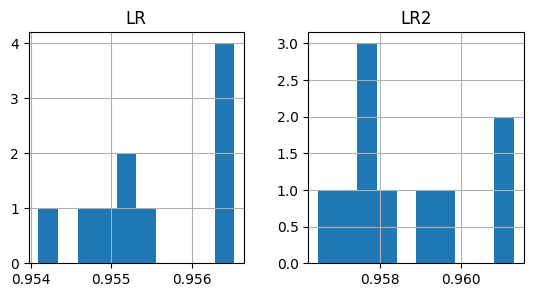

In [26]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

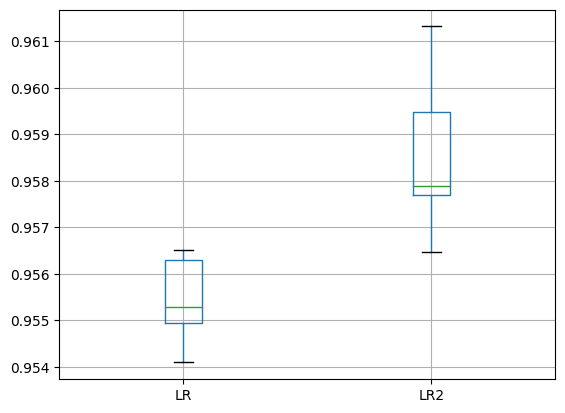

In [27]:
metrics.boxplot()

We compare the fscore_spam metric from LogisticRegression

In [28]:
metrics = pd.DataFrame({'LR_tfidf':LR_tfidf['test_fscore_spam'], 'LR_cvect': LR_cvect['test_fscore_spam']})
metrics

,LR_tfidf,LR_cvect
0,0.953776,0.955591
1,0.954317,0.957370
2,0.953851,0.957517
3,0.955608,0.957106
4,0.953978,0.958610
5,0.954748,0.957257
6,0.955605,0.959192
7,0.955823,0.960514
8,0.954048,0.956454
9,0.955722,0.960631


array([[<AxesSubplot: title={'center': 'LR_tfidf'}>,
        <AxesSubplot: title={'center': 'LR_cvect'}>, <AxesSubplot: >]],
      dtype=object)

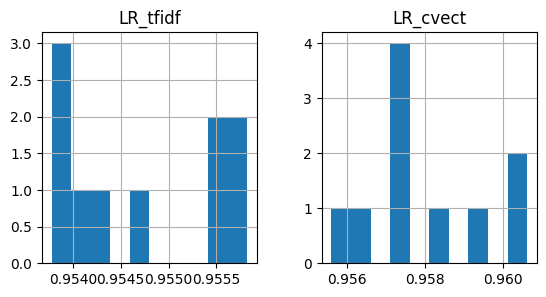

In [29]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

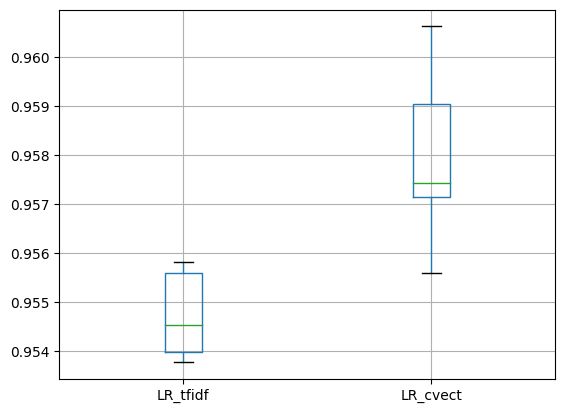

In [30]:
metrics.boxplot()

### SVC (with CountVectorizer)

In [31]:
start = time()
pipe = Pipeline([('vect', CountVectorizer()), ('clf', LinearSVC())])
SVC_cvect = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                    
                         return_estimator = True,
                         cv = kf,
                         n_jobs = -1) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(SVC_cvect)

elapsed = time()-start
print(elapsed)

/home/giacomo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/giacomo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/giacomo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/giacomo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/giacomo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/giacomo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinea

accuracy        0.976 [0.976, 0.975, 0.975, 0.975, 0.975, 0.975, 0.976, 0.976, 0.976, 0.976]
precision_ham   0.971 [0.97, 0.971, 0.969, 0.971, 0.971, 0.97, 0.971, 0.97, 0.971, 0.973]
recall_ham      0.981 [0.982, 0.98, 0.98, 0.98, 0.98, 0.981, 0.982, 0.983, 0.981, 0.98]
precision_spam  0.981 [0.981, 0.98, 0.98, 0.98, 0.98, 0.98, 0.982, 0.983, 0.981, 0.98]
recall_spam     0.97 [0.97, 0.971, 0.97, 0.97, 0.971, 0.969, 0.97, 0.97, 0.971, 0.972]

vocabulary size 415195.9
fit_time        85.0
score_time      1.0
248.56055402755737


### SVC (with TfidfTokenizer)

In [32]:
start = time()
pipe = Pipeline([('vect', TfidfVectorizer()), ('clf', LinearSVC())])
SVC_tfidf = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                    
                         return_estimator = True,
                         cv = kf,
                         n_jobs = -1) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(SVC_tfidf)

elapsed = time()-start
print(elapsed)

accuracy        0.978 [0.977, 0.978, 0.977, 0.978, 0.978, 0.978, 0.978, 0.977, 0.978, 0.978]
precision_ham   0.973 [0.971, 0.974, 0.972, 0.973, 0.974, 0.972, 0.972, 0.97, 0.974, 0.974]
recall_ham      0.983 [0.983, 0.982, 0.981, 0.982, 0.983, 0.983, 0.984, 0.985, 0.983, 0.983]
precision_spam  0.983 [0.983, 0.982, 0.982, 0.982, 0.983, 0.983, 0.984, 0.985, 0.982, 0.983]
recall_spam     0.972 [0.971, 0.973, 0.972, 0.973, 0.974, 0.972, 0.972, 0.97, 0.973, 0.974]

vocabulary size 415195.9
fit_time        19.0
score_time      1.0
59.15509581565857


### Comparing Metrics with different Models
We compare the fscore_spam metrics from LogisticRegression and LinearSVC

In [33]:
metrics = pd.DataFrame({'LR':LR_cvect['test_fscore_spam'], 'SVC': SVC_cvect['test_fscore_spam']})
metrics

,LR,SVC
0,0.955591,0.975493
1,0.957370,0.975183
2,0.957517,0.974664
3,0.957106,0.974847
4,0.958610,0.975181
5,0.957257,0.974938
6,0.959192,0.976325
7,0.960514,0.976445
8,0.956454,0.975655
9,0.960631,0.976311


array([[<AxesSubplot: title={'center': 'LR'}>,
        <AxesSubplot: title={'center': 'SVC'}>, <AxesSubplot: >]],
      dtype=object)

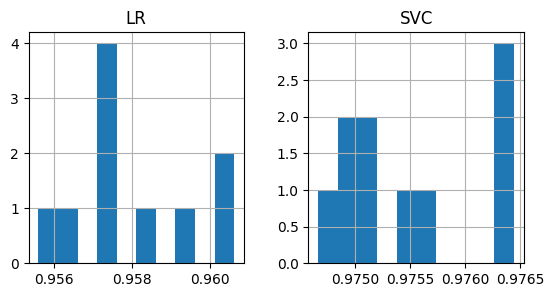

In [34]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

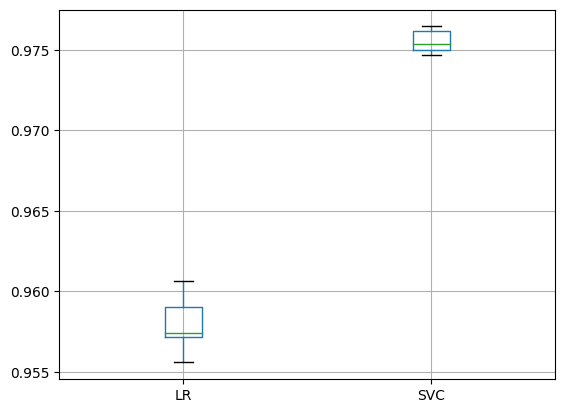

In [35]:
metrics.boxplot()

test accuracy 

In [36]:
metrics = pd.DataFrame({'LR':LR_cvect['test_accuracy'], 'SVC': SVC_cvect['test_accuracy']})
metrics

,LR,SVC
0,0.956465,0.975820
1,0.957956,0.975352
2,0.957691,0.974562
3,0.957808,0.974971
4,0.959036,0.975205
5,0.957721,0.975059
6,0.959621,0.976433
7,0.960849,0.976463
8,0.957282,0.975966
9,0.961317,0.976492


array([[<AxesSubplot: title={'center': 'LR'}>,
        <AxesSubplot: title={'center': 'SVC'}>, <AxesSubplot: >]],
      dtype=object)

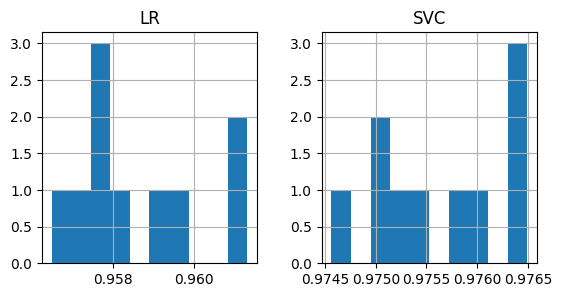

In [37]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

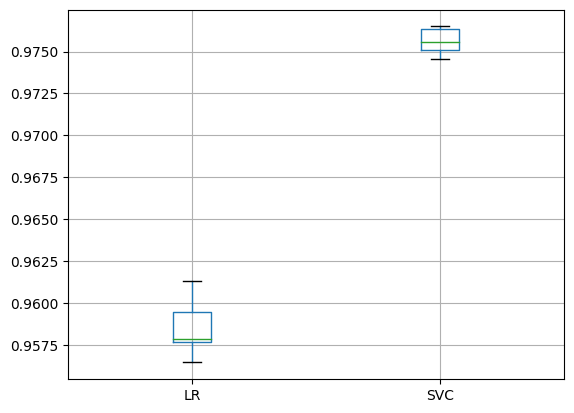

In [38]:
metrics.boxplot()

### Compare SVC with Different Vectorizer: Counter VS Tfidf

Fscore metrics comparison

In [39]:
metrics = pd.DataFrame({'SVC_cvect':SVC_cvect['test_fscore_spam'], 'SVC_tfidf': SVC_tfidf['test_fscore_spam']})
metrics

,SVC_cvect,SVC_tfidf
0,0.975493,0.976733
1,0.975183,0.977804
2,0.974664,0.976943
3,0.974847,0.977609
4,0.975181,0.978376
5,0.974938,0.977641
6,0.976325,0.977765
7,0.976445,0.977256
8,0.975655,0.977769
9,0.976311,0.978298


array([[<AxesSubplot: title={'center': 'SVC_cvect'}>,
        <AxesSubplot: title={'center': 'SVC_tfidf'}>, <AxesSubplot: >]],
      dtype=object)

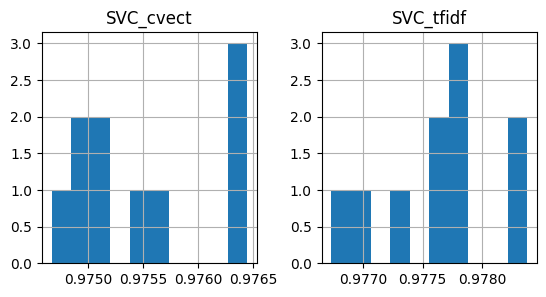

In [40]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

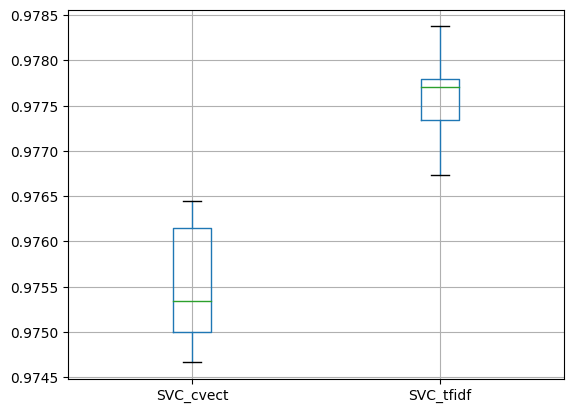

In [41]:
metrics.boxplot()

Accuracy metrics comparison

In [42]:
metrics = pd.DataFrame({'SVC_cvect':SVC_cvect['test_accuracy'], 'SVC_tfidf': SVC_tfidf['test_accuracy']})
metrics

,SVC_cvect,SVC_tfidf
0,0.975820,0.977048
1,0.975352,0.977955
2,0.974562,0.976843
3,0.974971,0.977720
4,0.975205,0.978392
5,0.975059,0.977749
6,0.976433,0.977866
7,0.976463,0.977281
8,0.975966,0.978042
9,0.976492,0.978480


array([[<AxesSubplot: title={'center': 'SVC_cvect'}>,
        <AxesSubplot: title={'center': 'SVC_tfidf'}>, <AxesSubplot: >]],
      dtype=object)

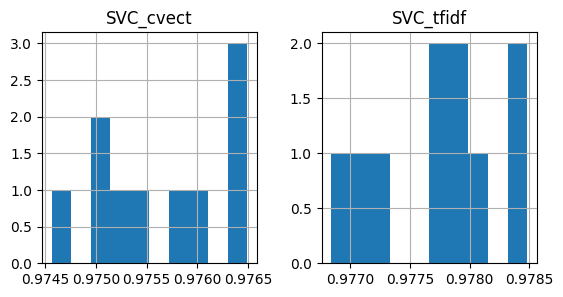

In [43]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

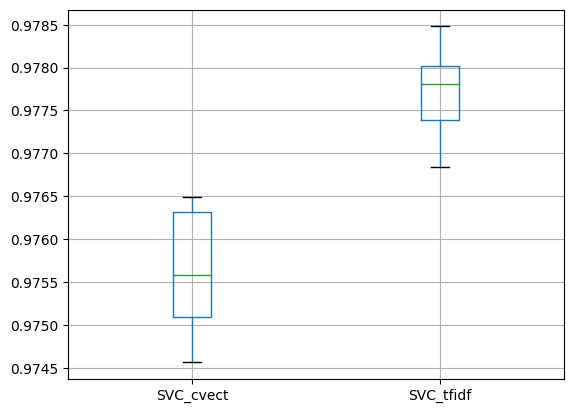

In [44]:
metrics.boxplot()